# Simulando las estrellas de la Vía Láctea 

#### Por Catalina Montecino y Justine Haefele (UTFSM)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import shutil
from scipy import stats
from scipy.interpolate import interp1d
import seaborn as sns
from scipy.stats import binned_statistic

# Funciones

In [23]:
def generar_masas_y_edades(N):
    """
    Genera masas estelares y edades aleatorias para N estrellas siguiendo la IMF de Kroupa (2001) mediante un método de selección de Montecarlo.
    
    Parámetros:
        N (int): Número de estrellas a generar.

    Retorna:
        lista_masas (np.array): Array de masas iniciales de las estrellas [M☉].
        ages (np.array): Array de edades asignadas aleatoriamente a las estrellas [Gyr].
    """
    # IMF de Kroupa (2001)
    def IMF(m):
        if 0.08 <= m < 0.5:
            alpha = 1.3
            return m**(-alpha)
        elif 0.5 <= m < 1:
            alpha = 2.3
            return 0.5 * m**(-alpha)
        else:
            alpha = 2.3
            return 0.5 * m**(-alpha)

    # Montecarlo
    masses = np.random.uniform(0.08, 100, N)
    puniform = np.random.uniform(0, 1, N)
    lista_masas = []

    # Normalización para que IMF(m)/IMF(0.08) quede entre 0 y 1
    IMF_min = IMF(0.08)

    for m, p in zip(masses, puniform):
        pIMF = IMF(m) / IMF_min
        if p <= pIMF:
            lista_masas.append(m)
            
    lista_masas = np.asarray(lista_masas)
    
    # Generación de edades
    n_stars = len(lista_masas)
    ages = np.random.uniform(0.01, 10, n_stars)  # en Gyr

    return lista_masas, ages


def clasificar_remanentes(lista_masas, ages):
    """
    Clasifica las estrellas como remanentes o en secuencia principal y determina el tipo de remanente 
    (enana blanca WD, estrella de neutrones NS, o agujero negro BH) según la masa inicial. Se interpola en
    los rangos en que se juntan las definiciones.

    Parámetros:
        lista_masas (np.array): Masas iniciales de las estrellas [M☉].
        ages (np.array): Edades de las estrellas [Gyr].

    Retorna:
        is_remnant (np.array, bool): Array booleano indicando si la estrella es remanente.
        remnant_masses (np.array): Masas de estrellas que ya son remanentes [M☉].
        ms_masses (np.array): Masas de estrellas en secuencia principal [M☉].
        wd_ini (np.array): Masas iniciales que producen enanas blancas [M☉].
        ns_ini (np.array): Masas iniciales que producen estrellas de neutrones [M☉].
        bh_ini (np.array): Masas iniciales que producen agujeros negros [M☉].
    """

    # Tiempo de vida en la secuencia principal
    t_ms = 1e-9 * (1e10 / lista_masas**2.5)  # en Gyr

    is_remnant = ages > t_ms
    remnant_masses = lista_masas[is_remnant]
    ms_masses = lista_masas[~is_remnant]

    # Clasificamos los remanentes en WD, NS, BH de acuerdo a su masa

    wd_ini = remnant_masses[remnant_masses <= 8]
    ns_ini = remnant_masses[(remnant_masses >= 9) & (remnant_masses < 15)]
    bh_ini = remnant_masses[remnant_masses > 18.5]

    # Clasificación de regiones ambiguas

    # Zona NS / BH: 15–18.5 M☉
    is_ns_or_bh = remnant_masses[(remnant_masses >= 15) & (remnant_masses <= 18.5)]

    random_p1 = np.random.uniform(0, 1, len(is_ns_or_bh))
    mask_ns1 = random_p1 < 0.6   # 60% NS
    mask_bh = ~mask_ns1          # 40% BH

    ns_random = is_ns_or_bh[mask_ns1]
    bh_random = is_ns_or_bh[mask_bh]

    ns_ini = np.concatenate((ns_ini, ns_random))
    bh_ini = np.concatenate((bh_ini, bh_random))

    # Zona WD / NS: 8–9 M☉
    is_wd_or_ns = remnant_masses[(remnant_masses > 8) & (remnant_masses <= 9)]

    random_p2 = np.random.uniform(0, 1, len(is_wd_or_ns))
    mask_wd = random_p2 < 0.7   # 70% WD
    mask_ns2 = ~mask_wd         # 30% NS

    wd_random = is_wd_or_ns[mask_wd]
    ns_random_from_wd = is_wd_or_ns[mask_ns2]

    wd_ini = np.concatenate((wd_ini, wd_random))
    ns_ini = np.concatenate((ns_ini, ns_random_from_wd))

    return (is_remnant,remnant_masses,ms_masses,wd_ini,ns_ini,bh_ini)


def masa_final_wds(masa_inicial):
    """
    Calcula la masa final de una enana blanca a partir de su masa inicial 
    usando la relación inicial-final de Kalirai et al. (2008).

    Parámetros:
        masa_inicial (float o np.array): Masas iniciales de estrellas progenitoras [M☉].

    Retorna:
        m_final_wds (float o np.array): Masas finales de las enanas blancas [M☉].
    """
    masa_inicial = np.asarray(masa_inicial)
    m_final_wds = 0.109 * masa_inicial + 0.394
    return m_final_wds

def masa_final_ns(masa_inicial):               
    """
    Calcula la masa final de una estrella de neutrones a partir de su masa inicial
    usando las ecuaciones por tramos de Raithel et al. (2018).

    Parámetros:
        masa_inicial (float o np.array): Masas iniciales de estrellas progenitoras [M☉].

    Retorna:
        mns (float o np.array): Masas finales de las estrellas de neutrones [M☉].
    """
    masa_inicial = np.asarray(masa_inicial)
    mns = np.full_like(masa_inicial, np.nan, dtype=float)

    # Tramo 1: 9 <= M <= 13
    mask1 = (masa_inicial >= 9) & (masa_inicial <= 13)
    mns[mask1] = (
        2.24
        + 0.508 * (masa_inicial[mask1] - 14.75)
        + 0.125 * (masa_inicial[mask1] - 14.75) ** 2
        + 0.0110 * (masa_inicial[mask1] - 14.75) ** 3
    )

    # Tramo 2: 13 < M < 15
    mask2 = (masa_inicial > 13) & (masa_inicial < 15)
    mns[mask2] = 0.123 + 0.112 * masa_inicial[mask2]

    # Tramo 3: 15 <= M < 17.8
    mask3 = (masa_inicial >= 15) & (masa_inicial < 17.8)
    mns[mask3] = 0.996 + 0.0384 * masa_inicial[mask3]

    # Tramo 4: 17.8 < M < 18.5
    mask4 = (masa_inicial > 17.8) & (masa_inicial < 18.5)
    mns[mask4] = -0.020 + 0.10 * masa_inicial[mask4]

    return mns

def masa_bh_core(masas_zams):
    """
    Calcula la masa del núcleo de un agujero negro según la masa inicial de la estrella (ZAMS),
    interpolando entre 40–45 M☉. 
    Considera una fracción de masa (fej) que la estrella eyecta al momento de la explosión de Supernova
    igual a 1, es decir, colapsa únicamente el núcleo de Helio. Esto es únicamente en el rango
    de masa 15 <= M <= 40. 
    

    Parámetros:
        masas_zams (float o np.array): Masas iniciales de la ZAMS [M☉].

    Retorna:
        mbh_core (float o np.array): Masa del núcleo del BH [M☉].
    """
    masas_zams = np.asarray(masas_zams)
    mbh_core = np.full_like(masas_zams, np.nan, dtype=float)

    # Branch I: 15 <= M <= 40. Utiliza una fej = 1
    mask1 = (masas_zams >= 15) & (masas_zams <= 40)
    mbh_core[mask1] = -2.049 + 0.4140 * masas_zams[mask1]

    # Branch II: 45 <= M <= 120. Considera la implosión del núcleo de CO, ya que no queda envoltura a estas altas masas.
    mask2 = (masas_zams >= 45) & (masas_zams <= 120)
    mbh_core[mask2] = 5.697 + 7.8598e8 * masas_zams[mask2]**(-4.858)

    # Interpolación lineal entre 40 y 45
    mask_interp = (masas_zams > 40) & (masas_zams < 45)
    if np.any(mask_interp):
        # Valores de los extremos
        x = [40, 45]
        y = [
            -2.049 + 0.4140 * 40,       # valor branch I en 40
            5.697 + 7.8598e8 * 45**-4.858  # valor branch II en 45
        ]
        f_interp = interp1d(x, y)
        mbh_core[mask_interp] = f_interp(masas_zams[mask_interp])

    return mbh_core


def masa_bh_all(masas_zams):
    """
    Calcula la masa total de un agujero negro a partir de la masa inicial de la estrella.
    Considera una fracción de masa (fej) que la estrella eyecta al momento de la explosión de Supernova
    igual a 0, es decir, colapsa toda la estrella. 

    Parámetros:
        masas_zams (float o np.array): Masas iniciales de la ZAMS [M☉].

    Retorna:
        mbh_all (float o np.array): Masa total del BH [M☉].
    """
    masas_zams = np.asarray(masas_zams)
    mbh_all = np.zeros_like(masas_zams, dtype=float)  # mismo tamaño que entrada

    mask = masas_zams >= 15
    mbh_all[mask] = (
        15.52
        - 0.3294 * (masas_zams[mask] - 25.97)
        - 0.02121 * (masas_zams[mask] - 25.97)**2
        + 0.003120 * (masas_zams[mask] - 25.97)**3
    )

    return mbh_all


def masa_bh_estandar(masas_zams, fej):
    """
    Calcula la masa final de un agujero negro combinando la masa del núcleo y la masa total
    según la fracción de masa 'fej' que ejecta la estrella al momento de la explosión de Supernova.  

    Parámetros:
        masas_zams (float o np.array): Masas iniciales de la ZAMS [M☉].
        fej (float): Fracción de la masa que proviene del núcleo.

    Retorna:
        mbh_estandar (float o np.array): Masa final del BH [M☉].
    """
    masas_zams = np.asarray(masas_zams)
    mbh_estandar = fej * masa_bh_core(masas_zams) + (1 - fej) * masa_bh_all(masas_zams)
    return mbh_estandar


def edades_extremas(ages, ms_idx, wd_idx, ns_idx, bh_idx):
    """
    Calcula las edades mínima y máxima para cada tipo de estrella (MS, WD, NS, BH)
    usando los índices de cada grupo.

    Parámetros:
        ages (np.array): Edades de todas las estrellas [Gyr].
        ms_idx, wd_idx, ns_idx, bh_idx (list o np.array): Índices de cada tipo de estrella.

    Retorna:
        extremos (dict): Diccionario con tuplas (edad_min, edad_max) para cada tipo.
    """
    extremos = {}
    tipos = {"MS": ms_idx, "WD": wd_idx, "NS": ns_idx, "BH": bh_idx}
    for tipo, idx in tipos.items():
        if len(idx) > 0:
            edades_tipo = ages[idx]
            extremos[tipo] = (edades_tipo.min(), edades_tipo.max())
        else:
            extremos[tipo] = (None, None)
    return extremos


############################################################### Figuras IFMR para cada remanente ###################################################################################


def graficar_subplots_inicial_final_color_edad(lista_masas, ages, wd_ini, ns_ini, bh_ini):
    """
    Genera 3 subplots mostrando la relación masa inicial–masa final para WD, NS y BH.
    Cada punto está coloreado según la edad de la estrella. Marca la estrella más joven y más vieja
    de cada tipo con símbolos. Considera una fej = 0.9 para los BH.

    Parámetros:
        lista_masas (np.array): Masas iniciales de todas las estrellas [M☉].
        ages (np.array): Edades de todas las estrellas [Gyr].
        wd_ini, ns_ini, bh_ini (np.array): Masas iniciales de remanentes WD, NS y BH [M☉].
    """
    
    # Masas finales
    wd_fin = masa_final_wds(wd_ini)
    ns_fin = masa_final_ns(ns_ini)
    bh_fin = masa_bh_estandar(bh_ini, fej=0.9)

    # Edades
    def edades_de(masas):
        idx = [np.argmin(np.abs(lista_masas - m)) for m in masas]
        return ages[idx]

    ages_wd = edades_de(wd_ini) if len(wd_ini) > 0 else np.array([])
    ages_ns = edades_de(ns_ini) if len(ns_ini) > 0 else np.array([])
    ages_bh = edades_de(bh_ini) if len(bh_ini) > 0 else np.array([])

    # Edades extremas
    wd_joven, wd_vieja = (np.min(ages_wd), np.max(ages_wd)) if len(ages_wd) > 0 else (None, None)
    ns_joven, ns_vieja = (np.min(ages_ns), np.max(ages_ns)) if len(ages_ns) > 0 else (None, None)
    bh_joven, bh_viejo = (np.min(ages_bh), np.max(ages_bh)) if len(ages_bh) > 0 else (None, None)

    fig = plt.figure(figsize=(18, 5))
    gs = fig.add_gridspec(1, 4, width_ratios=[1,1,1,0.05], wspace=0.3)
    ax0, ax1, ax2, cax = fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1]), fig.add_subplot(gs[0,2]), fig.add_subplot(gs[0,3])
    axes = [ax0, ax1, ax2]

    tipos = ["WD", "NS", "BH"]
    masas_inicial = [wd_ini, ns_ini, bh_ini]
    masas_final = [wd_fin, ns_fin, bh_fin]
    edades = [ages_wd, ages_ns, ages_bh]
    edades_extremas = [(wd_joven, wd_vieja), (ns_joven, ns_vieja), (bh_joven, bh_viejo)]

    marker = "s"
    cmap = plt.cm.Blues

    # Normalización de color
    edades_totales = np.concatenate([e for e in edades if len(e)>0])
    norm = plt.Normalize(vmin=np.min(edades_totales), vmax=np.max(edades_totales))

    for ax, tipo, x, y, edad, (emin, emax) in zip(axes, tipos, masas_inicial, masas_final, edades, edades_extremas):
        if len(x) == 0:
            ax.text(0.5, 0.5, f"No hay {tipo}", ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_axis_off()
            continue

        # Scatter principal
        sc = ax.scatter(x, y, c=edad, cmap=cmap, s=20, marker=marker, edgecolor="black", alpha=0.85, norm=norm)

        # Marca la estrella más joven
        if emin is not None:
            idx_min = np.argmin(edad)
            x_min, y_min = x[idx_min], y[idx_min]
            ax.scatter(x_min, y_min, color="red", s=100, edgecolor="black", marker='X',
                       label=f"Más joven = {emin:.2f} Gyr\nMi = {x_min:.2f}, Mf = {y_min:.2f}")

        # Marca la estrella más vieja
        if emax is not None:
            idx_max = np.argmax(edad)
            x_max, y_max = x[idx_max], y[idx_max]
            ax.scatter(x_max, y_max, color='yellow', s=100, edgecolor="black", marker='X',
                       label=f"Más vieja = {emax:.2f} Gyr\nMi = {x_max:.2f}, Mf = {y_max:.2f}")

        ax.set_title(f"{tipo}", fontsize=14)
        ax.set_xlabel("Masa inicial [M☉]")
        ax.set_ylabel("Masa final [M☉]")
        ax.set_xlim(min(x)*0.95, max(x)*1.05)
        ax.set_ylim(min(y)*0.95, max(y)*1.05)
        ax.legend(loc='upper left', fontsize=10)

    # Colorbar
    if len(edades_totales) > 0:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cax)
        cbar.set_label("Edad [Gyr]")

    plt.subplots_adjust(left=0.05, right=0.95, top=0.88, bottom=0.12)
    plt.show()

################################################ Funciones para graficar #################################################

def graficar_fracciones_y_edades(ms_masses, ages_ms, wd_ini, ages_wd, ns_ini, ages_ns, bh_ini, ages_bh, lista_masas=None, ages=None):
    """
    Grafica un histograma de barras con las fracciones de cada tipo de estrella (MS, WD, NS, BH)
    y muestra la edad mínima y máxima para cada tipo como información de leyenda.

    Parámetros:
        ms_masses, wd_ini, ns_ini, bh_ini (np.array): Masas de cada tipo de estrella [M☉].
        ages_ms, ages_wd, ages_ns, ages_bh (np.array): Edades de cada tipo [Gyr].
        lista_masas, ages (opcional): Masas y edades totales (para referencias si se desea).
    """
    
    tipos = ["MS", "WD", "NS", "BH"]

    # Cantidades y fracciones
    num_ms, num_wd, num_ns, num_bh = len(ms_masses), len(wd_ini), len(ns_ini), len(bh_ini)
    total = num_ms + num_wd + num_ns + num_bh
    fractions = [num_ms/total, num_wd/total, num_ns/total, num_bh/total]

    # Para obtener masas asociadas a edades mínimas y máximas
    def masa_por_edad(masas_tipo, edades_tipo):
        if len(edades_tipo) == 0:
            return (None, None), (None, None)
        idx_min = np.argmin(edades_tipo)
        idx_max = np.argmax(edades_tipo)
        return (edades_tipo[idx_min], masas_tipo[idx_min]), (edades_tipo[idx_max], masas_tipo[idx_max])

    joven_ms, vieja_ms = masa_por_edad(ms_masses, ages_ms)
    joven_wd, vieja_wd = masa_por_edad(wd_ini, ages_wd)
    joven_ns, vieja_ns = masa_por_edad(ns_ini, ages_ns)
    joven_bh, vieja_bh = masa_por_edad(bh_ini, ages_bh)

    plt.figure(figsize=(8,6))
    bars = plt.bar(tipos, fractions, edgecolor="k", alpha=0.7, color='blueviolet', hatch='//')

    # Fracciones sobre cada barra
    for i, bar in enumerate(bars):
        plt.text(i, bar.get_height() + 0.01, f"{fractions[i]:.3f}", ha='center', va='bottom', color='black', fontsize=10, fontweight='bold')

    # Leyenda
    legend_texts = []
    for tipo, joven, vieja in zip(tipos, [joven_ms, joven_wd, joven_ns, joven_bh],
                                  [vieja_ms, vieja_wd, vieja_ns, vieja_bh]):
        if joven[0] is not None:
            legend_texts.append(
                f"{tipo} Joven: {joven[0]:.2f} Gyr, {joven[1]:.2f} M☉; "
                f"{tipo} Vieja: {vieja[0]:.2f} Gyr, {vieja[1]:.2f} M☉"
            )
        else:
            legend_texts.append(f"{tipo} → No hay datos")

    plt.ylabel("Fracción")
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.legend(legend_texts, loc='upper right', fontsize=9)
    plt.show()



############################################## Función para gráficos opcionales #####################################################

def graficar_ifmr_ns_bh(ns_ini, bh_ini, mostrar=True):
    """
    Grafica la relación masa inicial - masa final (IFMR) para NS y BH.
    
    Parámetros:
        ns_ini (np.array): Masas iniciales de NS.
        bh_ini (np.array): Masas iniciales de BH.
        mostrar (bool): Si True muestra el gráfico; si False, no hace nada.
    """
    if not mostrar:
        return  # No mostrar gráficos si el usuario no quiere

    # Masas finales simuladas
    ns_final = masa_final_ns(ns_ini)
    bh_final_estandar = masa_bh_estandar(bh_ini, 0.9)

    # Rango para curvas teóricas
    M = np.linspace(9, 100, 800)
    m_grid = np.linspace(ns_ini.min(), ns_ini.max(), 600)
    m_ns_grid = masa_final_ns(m_grid)

    plt.figure(figsize=(18,5))

    # Curvas IFMR BH
    plt.plot(M, masa_bh_core(M), lw=3, label=r"$M_{\rm He}$ Core $f_{ej} = 1$")
    plt.plot(M, masa_bh_all(M), "--", lw=3, label=r"$M_{\rm preSN}$ All $f_{ej} = 0$")
    plt.plot(M, masa_bh_estandar(M, 0.9), "--", lw=3, label=r"$f_{ej} = 0.9$")

    # Curva IFMR NS
    plt.plot(m_grid, m_ns_grid, lw=2, color="blue", alpha=0.5, label="IFMR NS (Raithel+2018)")

    # Puntos simulados
    if len(ns_ini) > 0:
        plt.scatter(ns_ini, ns_final, s=45, alpha=0.6, color="red", edgecolor="k", linewidth=0.3, label="NS simuladas")
    if len(bh_ini) > 0:
        plt.scatter(bh_ini, bh_final_estandar, edgecolor="k", facecolor="none", s=45, label="BH simulados")

    plt.xlabel(r"$M_{\rm ZAMS} (M_\odot)$")
    plt.ylabel(r"$M_{\rm remanente} (M_\odot)$")
    plt.xlim(8, 100)
    plt.ylim(0, 20)
    plt.legend()
    plt.tight_layout()
    plt.show()



# Ejecución de las funciones: Main

Ingresa la semilla aleatoria:  123
Cantidad de estrellas a generar (sugerido 10.000.000):  10000000



Se generaron 14905 estrellas tras muestreo Monte Carlo.
Número de remanentes: 920
Número de MS: 13985


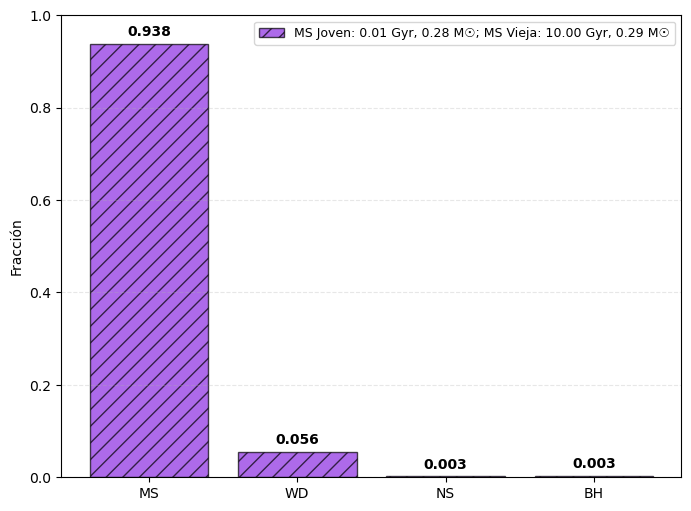

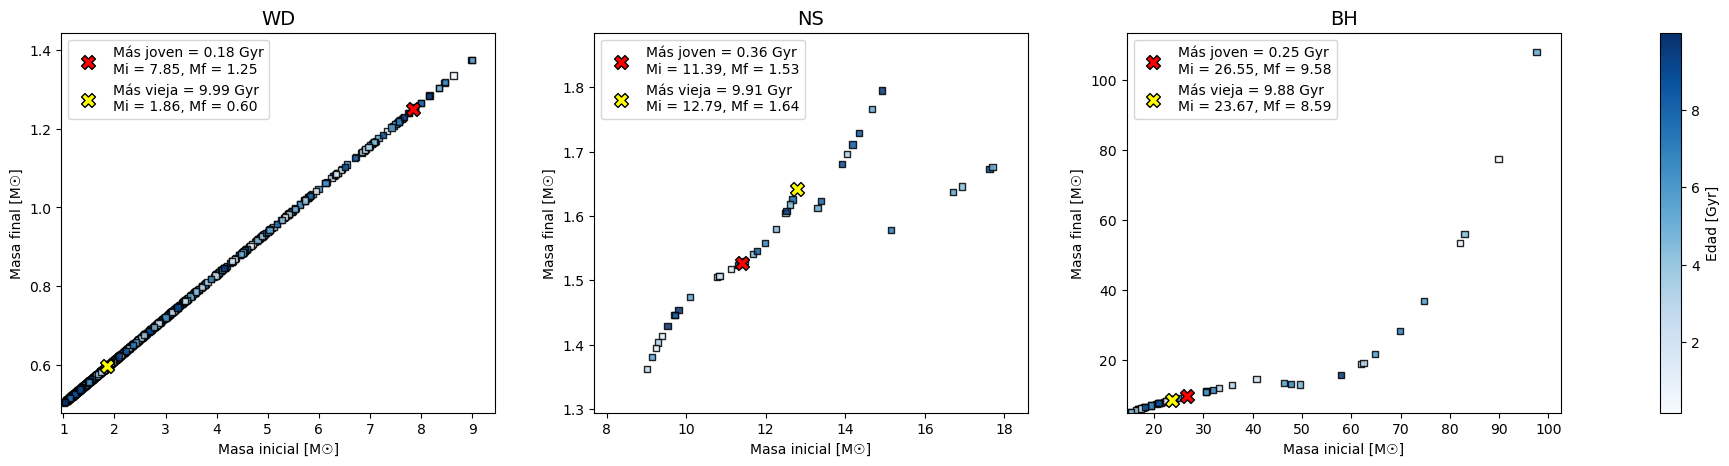

¿Deseas ver la IFMR para BH y NS con las curvas teóricas? (y/n):  y


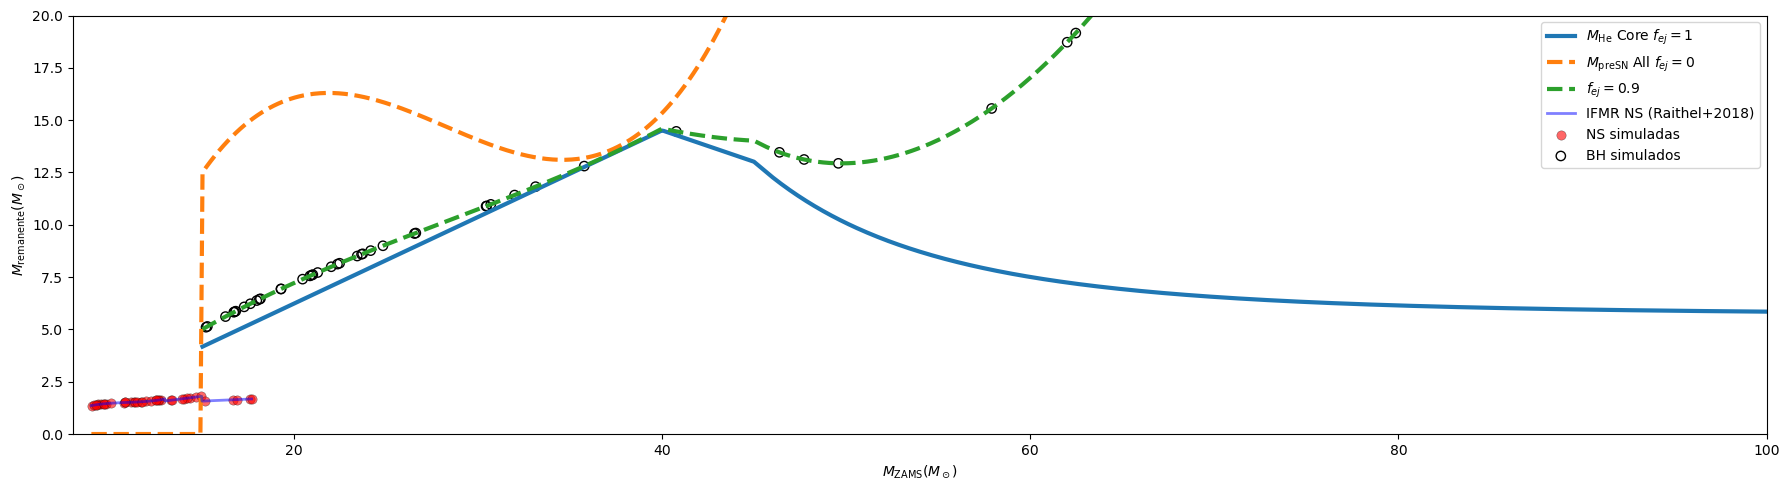

In [24]:
def main():

    # Inputs pedidos al usuario
    seed = int(input("Ingresa la semilla aleatoria: "))
    N = int(input("Cantidad de estrellas a generar (sugerido 10.000.000): "))
    np.random.seed(seed)

    # Se generan las masas y edades de las estrellas
    lista_masas, ages = generar_masas_y_edades(N)

    # Se clasifican las estrellas de acuerdo a si remanentes o MS stars
    is_remnant, remnant_masses, ms_masses, wd_ini, ns_ini, bh_ini = clasificar_remanentes(lista_masas, ages)

    # Índices para MS y remanentes
    ms_idx = np.where(~is_remnant)[0]
    remnant_idx = np.where(is_remnant)[0]

    # Máscaras para WD, NS, BH
    wd_mask = np.isin(remnant_masses, wd_ini)
    ns_mask = np.isin(remnant_masses, ns_ini)
    bh_mask = np.isin(remnant_masses, bh_ini)

    wd_idx = remnant_idx[wd_mask]
    ns_idx = remnant_idx[ns_mask]
    bh_idx = remnant_idx[bh_mask]

    # Edades MS y remanentes
    ages_ms = ages[ms_idx]
    ages_wd = ages[wd_idx]
    ages_ns = ages[ns_idx]
    ages_bh = ages[bh_idx]


    print(f"\nSe generaron {len(lista_masas)} estrellas tras muestreo Monte Carlo.")
    print(f"Número de remanentes: {len(remnant_masses)}")
    print(f"Número de MS: {len(ms_masses)}")

    graficar_fracciones_y_edades(ms_masses, ages_ms, wd_ini, ages_wd, ns_ini, ages_ns, bh_ini, ages_bh, lista_masas, ages)
    graficar_subplots_inicial_final_color_edad(lista_masas, ages, wd_ini, ns_ini, bh_ini)

    ver_graficos = input("¿Deseas ver la IFMR para BH y NS con las curvas teóricas? (y/n): ").lower() == 'y'
    if ver_graficos:

        graficar_ifmr_ns_bh(ns_ini, bh_ini, mostrar=True)

if __name__ == "__main__":
    main()
    